# TD5 : Regularization

In [35]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from scipy.linalg import svd, svdvals
import numpy as np
import pandas as pd
from src.utils import Event
import matplotlib.pyplot as plt

In [5]:
evt = Event(effective_rank=3, noise_level=1)
batch1_X, batch1_y = evt.sample(n_samples=100)
batch2_X, batch2_y = evt.sample(n_samples=200)

In [19]:
evt.effective_rank

3

In [17]:
batch1_X.shape

(100, 10)

In [18]:
batch1_y.shape

(100,)

1) Using a SVD, compute the singular values di, 1 ⩽i ⩽k of X. What is the effect of the parameter effective_rank? What is the effective rank supposed to model ?

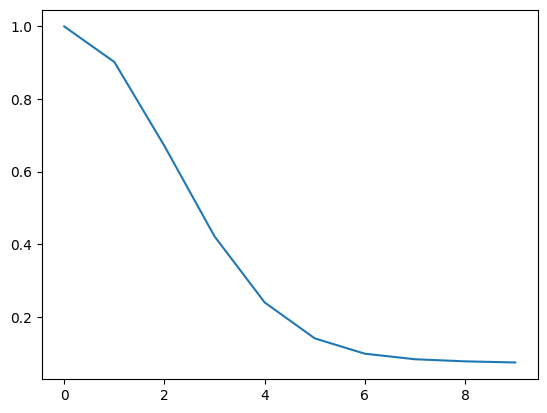

In [22]:
U, S, V = svd(batch1_X)
plt.plot(S)

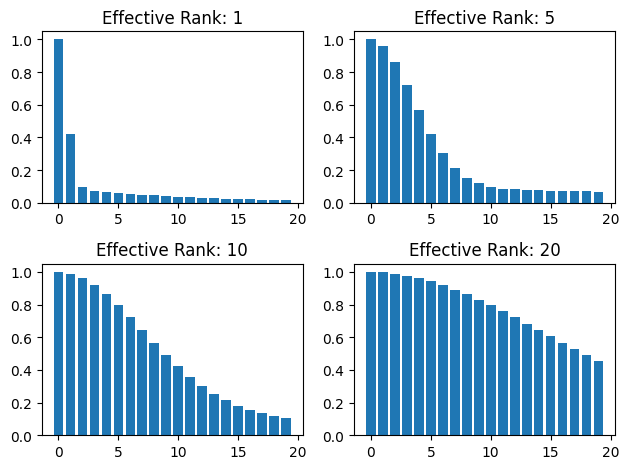

In [33]:
fig, axs = plt.subplots(2, 2)
for index, effective_rank in enumerate((1, 5, 10, 20)):
    evt = Event(n_features = 20, effective_rank=effective_rank, noise_level=1)
    X, y = evt.sample(n_samples=100)
    S = svdvals(X)
    
    # Convert index to a 2D grid index
    ax = axs[index // 2, index % 2]
    ax.bar(range(len(S)), S)
    ax.set_title(f"Effective Rank: {effective_rank}")

plt.tight_layout()
plt.show()

Effective rank refers to the number of components we have to keep.

2) By repeatedly fitting each model on the same Event object, give an estimate of the bias,
variance and risk of the estimator at a chosen point.

In [34]:
event = Event(n_features=50, effective_rank=25)
X, y = event.sample(n_samples=200)

In [67]:
# Different models to probe

models = {
    "Linear Regression" : LinearRegression(),
    "Ridge" : Ridge(),
    "Lasso" : Lasso()
}

y_predictions = {name : [] for name in models}

n_trials = 100
event = Event(n_features=50, effective_rank=3)
true_beta = event.coefficients
X, y = event.sample(n_samples=200)

In [68]:
# Point to estimate
x0 = X[0]
y0_true_pred = x0 @ true_beta

# N tries
for _ in range(n_trials) :
    # Generate dataset
    X, y = event.sample(n_samples=200)
    # Learn all models
    for name, model in models.items():
        model.fit(X, y)
        y_predictions[name].append(model.predict(x0.reshape(1, -1)))


for name in models:
    var = np.var(y_predictions[name])
    bias = np.mean(y_predictions[name]) - y0_true_pred
    y0s = y0_true_pred + evt.model_noise * np.random.randn(n_trials)
    risk = np.mean((y_predictions[name] - y0s)**2)
    print(name)
    print("----Variance :", var)
    print("----Bias : ", bias)
    print("----Risk : ", risk)


Linear Regression
----Variance : 11.36778296287929
----Bias :  0.1451026254846144
----Risk :  11.639726270563978
Ridge
----Variance : 0.40959844869773127
----Bias :  0.929646047083164
----Risk :  1.4048444206914876
Lasso
----Variance : 0.2745770626209034
----Bias :  1.944028477174243
----Risk :  3.9735381244342456


Show the influence of the dataset’s effective rank on the 3 algorithms and interpret.

In [74]:
n_features = 50
var = {name : [] for name in models}
bias = {name : [] for name in models}
risk = {name : [] for name in models}

for effective_rank in range(1, n_features):
    # Generate event
    event = Event(n_features=n_features, effective_rank=effective_rank)
    y_predictions = {name : [] for name in models}

    # N tries
    for _ in range(n_trials) :
        # Generate dataset
        X, y = event.sample(n_samples=200)
        # Learn all models
        for name, model in models.items():
            model.fit(X, y)
            y_predictions[name].append(model.predict(x0.reshape(1, -1)))


    for name in models:
        variance = np.var(y_predictions[name])
        biais = np.mean(y_predictions[name]) - y0_true_pred
        y0s = y0_true_pred + evt.model_noise * np.random.randn(n_trials)
        ris = np.mean((y_predictions[name] - y0s)**2)

        var[name].append(variance)
        bias[name].append(biais)
        risk[name].append(ris)


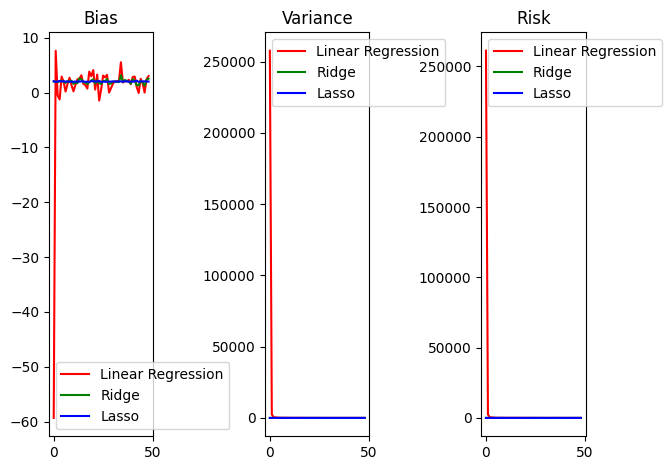

In [75]:
colors = ["red", "green", "blue"]

fig, axs = plt.subplots(nrows=1, ncols=3)
for index, model in enumerate(models):
    name = model  # Utilisation du modèle pour extraire les données
    axs[0].plot(bias[name], color=colors[index], label=name)
    axs[1].plot(var[name], color=colors[index], label=name)
    axs[2].plot(risk[name], color=colors[index], label=name)

axs[0].set_title('Bias')
axs[1].set_title('Variance')
axs[2].set_title('Risk')

for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()
